In [224]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os
import pandas as pd
from sklearn.metrics import accuracy_score

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img, img_to_array
from keras.models import load_model
from keras.preprocessing import image
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

import models.simpleConv as simpleConv
from imgaug import augmenters as iaa

import h5py
from imgaug import augmenters as iaa

import utils
import preprocessing as pp
pp.init()

allTrainingFolders = [x for x in os.listdir(pp.trainPath) if x.startswith('n')]


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Checking to make sure output directories are created..
..done


# Parsing & Data Loading

Parsing images for class ID: n01443537
Parsing images for class ID: n01491361
Parsing images for class ID: n01494475
Parsing images for class ID: n01440764
Parsing images for class ID: n01484850


Shuffling dataset: x_train


ValueError: Unknown format code 'f' for object of type 'str'

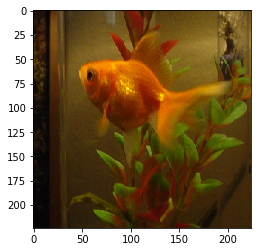

In [208]:
pp.displayImage(x_t[0])

In [238]:
encoder = LabelBinarizer()
##MAKE SURE classLabels is set to ALL the folders you will train on, even if doing in batches
encoder = encoder.fit(allTrainingFolders) 

parse = True
includeAugmented = False
onlyAugmented = False
augments = [iaa.GaussianBlur(3.0)]
h5filename = 'all.h5'

if parse:
    pp.parseImages(trainingFolders, h5filename)
    
#NOTE: KEEP BATCH SIZE = # of all folders for now because we need to shuffle H5. 
batch_size = 5
folderBatches = utils.chunks(allTrainingFolders, batch_size)
# print(folderBatches)

callbacks = []
epochs = 1

model = simpleConv.build_model(pp.img_width, pp.img_height, 3)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
all_x_val = []
all_y_val = []
all_x_train = []
all_y_train = []
# for batch in folderBatches:
    ##LOAD IN DATA

x_train, y_train, x_val, y_val = pp.loadH5(h5filename)

x_aug = []
y_aug = []
if includeAugmented:
    x_aug, y_aug = pp.augmentData(x_train, y_train, augments = augments)
    if onlyAugmented:
        x_train = x_aug
        y_train = y_aug
    else:
        x_train.extend(x_aug)
        y_train.extend(y_aug)


y_train = encoder.transform(y_train) #call encoder.inverse_transform() to get real class labels
y_val = encoder.transform(y_val)

#this is only needed if you are doing individual batches somehow. ignore for now. 
all_y_val.extend(y_val)
all_x_val.extend(x_val)
all_y_train.extend(y_train)
all_x_train.extend(x_train)


##FIT MODEL

# print("Fitting model on folder batch: {0}".format(batch))
results = model.fit(np.array(x_train), np.array(y_train), 
                    validation_data = (np.array(x_val), np.array(y_val)),
                    epochs=epochs, verbose=1, callbacks = callbacks)
    

#     model.train_on_batch(np.array(x_train), np.array(y_train))

    
#TODO:
#1. Need to shuffle the data that we're loading in, so that each call to fit has a sample for each class. 

Parsing images for class ID: n01443537
Parsing images for class ID: n01491361
Parsing images for class ID: n01494475
Parsing images for class ID: n01440764
Parsing images for class ID: n01484850
Train on 2070 samples, validate on 519 samples
Epoch 1/1
2070/2070 [==============================] - 148s 72ms/step - loss: 1.1588 - acc: 0.4768 - val_loss: 1.1205 - val_acc: 0.5222


In [171]:
val_scores = model.evaluate(np.array(all_x_val), np.array(all_y_val))
train_scores = model.evaluate(np.array(all_x_train), np.array(all_y_train))



2070/2070 [==============================] - 42s 20ms/step


In [172]:
print(model.metrics_names)
print("val: {0}".format(val_scores))
print("train: {0}".format(train_scores))


['loss', 'acc']
val: [0.9152405714483389, 0.5761078999795896]
train: [0.8406962091796064, 0.6183574880954724]


# MODEL: BUILDING + TRAINING

In [76]:
callbacks = []
epochs = 1

model = simpleConv.build_model(pp.img_width, pp.img_height, 3)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

results = model.fit(np.array(x_train), np.array(y_train), 
                    validation_data = (np.array(x_val), np.array(y_val)),
                    epochs=epochs, verbose=1, callbacks = callbacks)


Train on 4140 samples, validate on 519 samples
Epoch 1/1
4140/4140 [==============================] - 271s 65ms/step - loss: 1.0210 - acc: 0.5471 - val_loss: 0.9161 - val_acc: 0.6050


# EVALUATION

In [239]:
predictions = model.predict(np.array(x_val))

In [240]:

#PRINT PREDICTION CLASSES
print(pp.topClasses(predictions[504], encoder.classes_))

#LOAD PREDICTIONS INTO DATAFRAME, compute accuracy
def predictionsToDataframe(predictions, truth, encoder):
    one = []
    two = []
    three = []
    for p in predictions:
        top = pp.topClasses(p, encoder.classes_)
        one.append(top[0][0])
        two.append(top[1][0])
        three.append(top[2][0])
        
    df = pd.DataFrame({'truth': [pp.translateID(x) for x in encoder.inverse_transform(truth)],
                      'one': one,
                      'two': two,
                      'three': three}) 

    return df

df = predictionsToDataframe(predictions, y_val, encoder)

[('great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 0.41387945), ('tiger shark, Galeocerdo cuvieri', 0.2816862), ('hammerhead, hammerhead shark', 0.19379242)]


In [241]:
acc = len(df[df.truth == df.one])/len(df)
print("Top-1 accuracy: {0}".format(acc))

acc = len(df[(df.truth == df.one) | (df.truth == df.two)])/len(df)
print("Top-2 accuracy: {0}".format(acc))

acc = len(df[(df.truth == df.one) | (df.truth == df.two) | (df.truth == df.three) ]) / len(df)
print("Top-3 accuracy: {0}".format(acc))

# df.iloc[504]

Top-1 accuracy: 0.5221579961464354
Top-2 accuracy: 0.7398843930635838
Top-3 accuracy: 0.9248554913294798


Steps
1. Parse Image Data for all folders that you want to train on
2. Load in each batch and repeat:
    3. Apply augments to batch, if any
    4. Train batch
5. Evaluate model. 

In [155]:


#Wish list: 

# top-k accuracy during training
# training on batches in a smart way: batch generator and database on disk, probably. 
# look into nb_epoch and data generators
# https://stackoverflow.com/questions/33900486/shuffle-hdf5-dataset-using-h5py



['n01443537', 'n01491361']